## HMM EXAMPLE  with Continuous Densities

This example is very similar to the example in the course notes.
However there is no numerical exact match

In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline    
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

import pyspch.stats.probdist as Densities
from pyspch.stats import libhmm
import pyspch.display as Spd
import pyspch.core as Spch

# print all variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# graphical and print preferences
cmap_1 = sns.light_palette("caramel",50,input="xkcd")
cmap_2 = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_3 = sns.light_palette("caramel",50,input="xkcd")[25:50]
cmap = cmap_2
pd.options.display.float_format = '{:,.3f}'.format

# catch future warnings -- occurring in matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
#mpl.rcParams['ps.papersize'] = 'A4'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
    column-width: 60px;
    color: black !important;
}

,prior,mean,var
0,0.200,[1.0],[1.0]
1,0.200,[10.0],[1.0]
2,0.200,[15.0],[1.0]
3,0.200,[6.0],[1.0]
4,0.200,[2.0],[1.0]


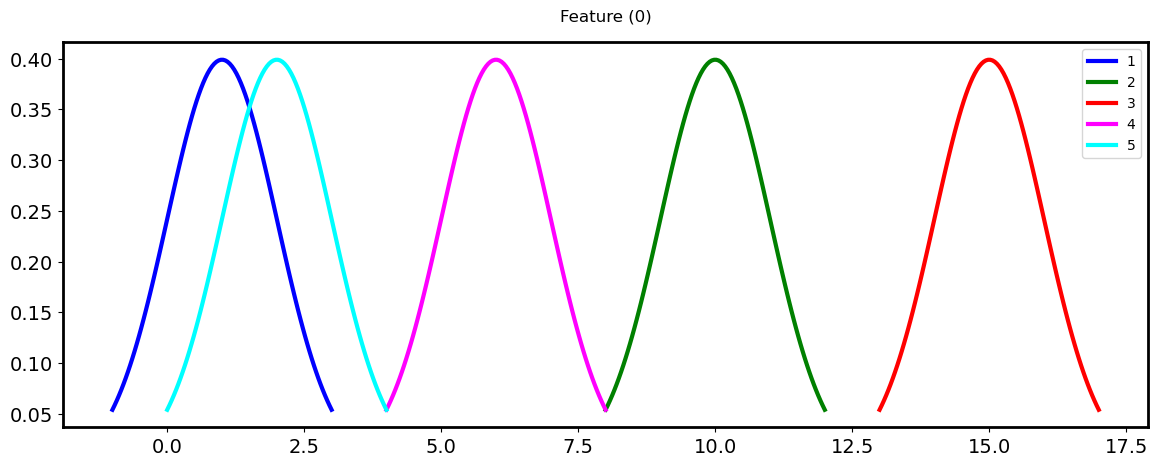

In [5]:
Gauss1 = Densities.Gaussian()
mu = np.array([ [1.0] , [10.], [15.], [6.], [2.] ])
var = 1.*np.ones(mu.shape)
X1 =np.array( [ 1.,1.,8.,10.,12.,4.,4.5,3.,4.5,4.5,3.,0. ] ).reshape(-1,1)
X2 = X1 + np.random.normal(scale=1., size=X1.shape)
Gauss1.init_model(mu=mu,var=var,classes=[1,2,3,4,5])
Gauss1.print_model()
Gauss1.plot_model()

In [6]:
Gauss1.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'n_classes': 5,
 'n_features_in_': 1,
 'theta_': array([[ 1.],
        [10.],
        [15.],
        [ 6.],
        [ 2.]]),
 'var_': array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 'classes_': array([1, 2, 3, 4, 5]),
 'class_prior_': array([0.2, 0.2, 0.2, 0.2, 0.2])}

### HMM with a Gaussian Observation Model

The frame classifiers above did not make use of the inherent sequence property of our data. We will now exploit the fact that we expect the data to be drawn in sequence from states 0-1-2.  Though we will not enforce this 100% as occasionally there are random switches between states.   

We make two hmm-models with the same init and transition probabilities.  
The model has a tendency left-to-right, though a very small probability allows for breaking this topology
- hmm1 : uses Gauss1 (intuitive) as observation model
- hmm2 : uses Gauss2 (trained) as observation model

We use log-prob's throughout to accomodate for small probs and long sequences

In [7]:
hmm1 = libhmm.HMM(prob_style="log",obs_model=Gauss1,n_states=5,prob_floor=1.e-20)
hmm1.init_topology(type="lr",selfprob=.8)
hmm1.print_model()


HMM STATE MODEL



,1,2,3,4,5
Pinit(.),0.000,-46.052,-46.052,-46.052,-46.052


,1,2,3,4,5
P(1|.),-0.223,-46.052,-46.052,-46.052,-46.052
P(2|.),-1.609,-0.223,-46.052,-46.052,-46.052
P(3|.),-46.052,-1.609,-0.223,-46.052,-46.052
P(4|.),-46.052,-46.052,-1.609,-0.223,-46.052
P(5|.),-46.052,-46.052,-46.052,-1.609,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.200,[1.0],[1.0]
1,0.200,[10.0],[1.0]
2,0.200,[15.0],[1.0]
3,0.200,[6.0],[1.0]
4,0.200,[2.0],[1.0]


## Trellis Computatitons

In the next cell
- Select model  hmm1 or hmm2
- Select Datastream and reference alignment  (X1,X2,X3,X4 or X2s,X3s,X4s)
- Compute the Viterbi Trellis (Normalize=True: max value =1.0 for prob or 0.0 for logprob)

In [8]:
X = X2
hmm = hmm1
tr = libhmm.Trellis(hmm)
tr.viterbi_pass(X)
tr.print_trellis(what=['obs_probs','probs'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8,9,10,11
1,-1.240,-1.754,-33.895,-35.084,-87.326,-2.542,-5.521,-3.720,-5.863,-8.364,-8.306,-2.007
2,-34.528,-53.888,-1.305,-1.188,-9.513,-26.825,-18.717,-22.918,-18.062,-14.135,-14.213,-55.781
3,-88.021,-117.851,-18.200,-17.357,-1.284,-75.315,-61.048,-68.584,-59.840,-52.341,-52.495,-120.656
4,-9.733,-20.717,-5.789,-6.253,-34.096,-6.033,-2.852,-4.386,-2.640,-1.570,-1.588,-21.882
5,-0.939,-3.547,-26.274,-27.318,-74.680,-1.240,-2.987,-1.853,-3.218,-5.005,-4.962,-3.982



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8,9,10,11
1,-1.240,-3.218,-37.335,-72.642,-140.921,-59.031,-64.775,-68.718,-74.804,-82.162,-84.777,-80.289
2,-80.579,-56.737,-6.132,-7.544,-17.280,-44.328,-63.268,-86.409,-88.390,-87.934,-90.684,-134.063
3,-134.073,-165.143,-67.469,-25.099,-10.437,-85.975,-106.986,-133.461,-130.420,-126.140,-128.966,-198.938
4,-55.785,-68.009,-55.059,-58.437,-60.805,-18.079,-21.154,-25.763,-28.626,-30.420,-32.230,-54.335
5,-46.990,-50.537,-75.543,-79.501,-128.275,-57.729,-22.675,-24.528,-27.747,-32.752,-36.991,-37.821


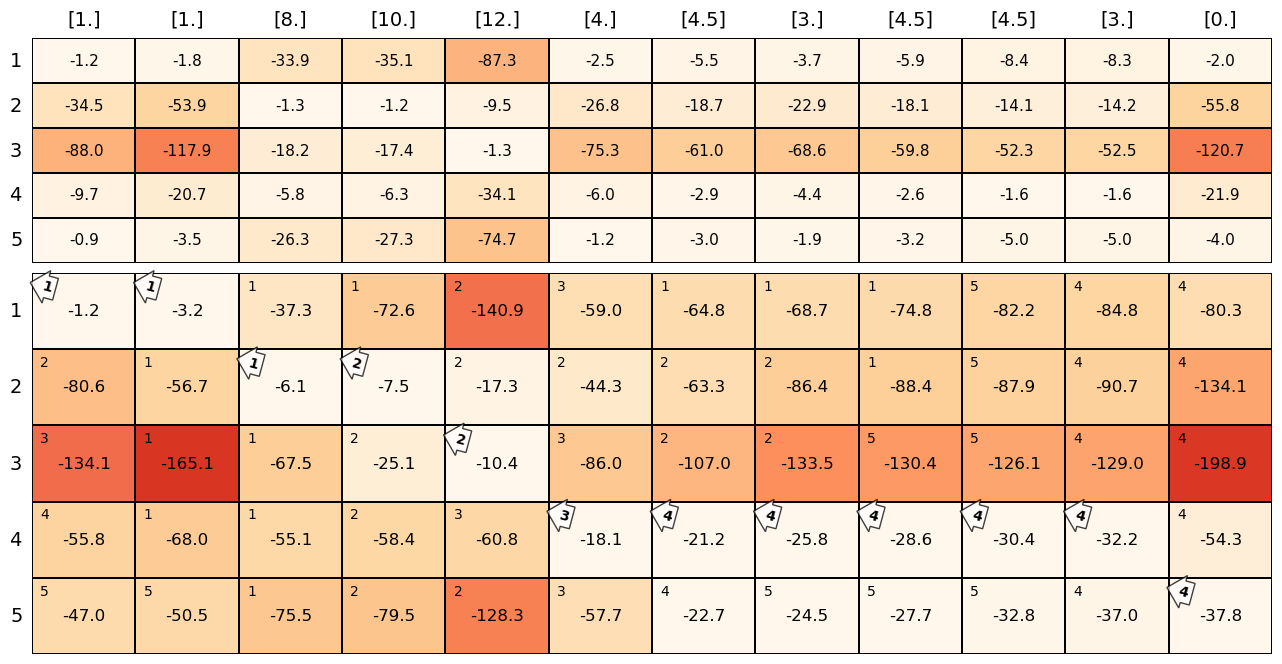

In [9]:
cmap="OrRd_r"
# column by column normalization is applied for the heatmap plotting of the trellis, 
tr.plot_trellis(xticks=X1,plot_norm=True,plot_obs_probs=True,plot_values=True,fmt=".1f",vmin=-220,vmax=0,
                 cmap=cmap,plot_backptrs=True,plot_alignment=True,figsize=(16,8))